In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt

'''#import plotly for interactive chart
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='richwolff', api_key='v0qPC120X33yPvAMDQXi')
from plotly.graph_objs import * '''

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from collections import defaultdict
%matplotlib inline

<h2>Load books into dataframe</h2>

In [2]:
d = defaultdict(list)

strtofind = r'";"'
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        d[i] = re.sub(strtofind,'||',line.replace('&amp;','&')).replace('"','').replace('\n','').split('||')
        
books_df = pd.DataFrame(data=list(d.values())[1:],index=list(d.keys())[1:],columns=d[0])
del d

In [3]:
## https://en.wikipedia.org/wiki/List_of_ISBN_identifier_groups
def book_lan_nationality(x):
    if x in ('0','1'):
        return 'English'
    elif not x in ('2','3','4','5','7'):
        return 'Other'
    elif x == '2':
        return 'French'
    elif x == '3':
        return 'German'
    elif x == '4':
        return 'Japan'
    elif x == '5': 
        return 'former USSR'
    elif x == '7': 
        return 'China'
    return None

books_df['origin'] = books_df['ISBN'].str.slice(0,1).apply(book_lan_nationality)
books_df['1st_3_publisher'] =books_df['ISBN'].str.slice(0,4).apply(lambda x: x[1:4] if x[0] in ('0','1','2','3','4','5','7') else 'Other')
books_df.sort_values(['origin','1st_3_publisher']).head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,origin,1st_3_publisher
243630,706400402X,Oriental Rugs and Carpets,Stanley Reed,0,Octopus Books,http://images.amazon.com/images/P/706400402X.0...,http://images.amazon.com/images/P/706400402X.0...,http://images.amazon.com/images/P/706400402X.0...,China,064
79353,7108009153,Zi ben zhu yi yu er shi yi shi ji,Ray Huang,1997,Jing xiao Xin hua shu dian,http://images.amazon.com/images/P/7108009153.0...,http://images.amazon.com/images/P/7108009153.0...,http://images.amazon.com/images/P/7108009153.0...,China,108
226475,710800982X,Wan li shi wu nian (Huang Renyu zuo pin xi lie),Ray Huang,1997,Jing xiao Xin hua shu dian,http://images.amazon.com/images/P/710800982X.0...,http://images.amazon.com/images/P/710800982X.0...,http://images.amazon.com/images/P/710800982X.0...,China,108
19579,7119020412,Tales From Ancient China's Imperial Harem,Yuan Yang,1998,Foreign Languages Press,http://images.amazon.com/images/P/7119020412.0...,http://images.amazon.com/images/P/7119020412.0...,http://images.amazon.com/images/P/7119020412.0...,China,119
125185,711900557X,"The pocket interpreter, Chinese",Lydia Chen,1988,Foreign Languages Press,http://images.amazon.com/images/P/711900557X.0...,http://images.amazon.com/images/P/711900557X.0...,http://images.amazon.com/images/P/711900557X.0...,China,119


<H2> Load Users Into DF </H2>

In [4]:
## Load users file and display first 5 rows
users_df = pd.read_csv('../data/raw/BX-Users.csv',sep=';',encoding='8859')
users_df.tail(5)

,User-ID,Location,Age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


<h3>There may be similarities of books read within certain age ranges. I'll create a category of age ranges to see if we can increase the accuracy of our model</h3>

(0, 100)

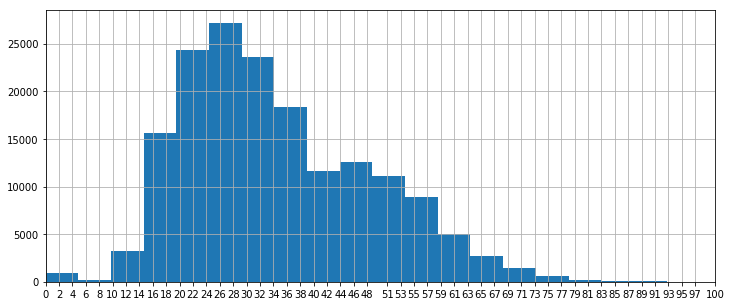

In [5]:
users_df['Age'].hist(bins=50,figsize=(12,5))
plt.xticks(np.linspace(0,100,50,dtype=np.int));
plt.xlim(0,100)

Age Ranges:
<ul>
<LI>LT 16</LI><LI>16 - 20</LI><LI>20 - 30</LI><LI>30 - 40</LI><LI>40 - 55</LI><LI>55+</LI>
</UL>

In [6]:
def age_range(x):
    if x < 16:
        return 'LT 16'
    elif x >=16 and x < 20:
        return '16-20'
    elif x >=20 and  x < 30:
        return '20-30'
    elif x >=30 and x < 40:
        return '20-40'
    elif x >=40 and x < 55:
        return '40-55'
    elif x >= 55:
        return 'GT 55'
    else:
        return 'Unknown'
users_df['age_range'] = users_df['Age'].apply(age_range)

<h2>Load User Ratings Of Books</h2>

In [7]:
ratings_df = pd.read_csv('../data/raw/BX-Book-Ratings.csv',sep=';',encoding='8859',dtype={'Book-Rating':np.int}).sort_values('User-ID')
ratings_df.head()

,User-ID,ISBN,Book-Rating
9561,2,0195153448,0
9562,7,034542252,0
9572,8,0771025661,0
9580,8,1881320189,7
9579,8,1575663937,6


In [8]:
## Join user and book data to ratings data
ratings = ratings_df.set_index('User-ID').join(users_df.set_index('User-ID')).reset_index().set_index('ISBN').join(books_df.set_index('ISBN'))

## Split out users from the USA
us_ratings = ratings[(ratings['Location'].str.lower().str.contains('usa')) | (ratings['Location'].str.lower().str.contains('states'))].reset_index()
us_ratings.head()

bk_platform_popularity = us_ratings.groupby('ISBN')[['User-ID','Book-Rating']].agg({'User-ID':'count','Book-Rating':np.mean})
bk_platform_popularity.columns = ['platform_popularity','platform_avg_rating']
bk_platform_popularity['platform_popularity_popularity_percent']= bk_platform_popularity['platform_popularity']/np.max(bk_platform_popularity['platform_popularity'])

<h2>Drop books that have only been read once. These can not be used for good recommendations</h2>

In [9]:
# How many times a book must have been read to keep it in ratings
min_book_read_count = 3

isbn_val_counts = us_ratings['ISBN'].value_counts()
books_to_keep = set(isbn_val_counts[isbn_val_counts>=min_book_read_count].index)

filtered_us_ratings = us_ratings[us_ratings['ISBN'].isin(books_to_keep)]

<h2>Split data into training and test sets</h2>

In [10]:
ratings_us_training,ratings_us_test = train_test_split(filtered_us_ratings,test_size=.20,random_state=21)

In [11]:
ratings_us_training.head()

,ISBN,User-ID,Book-Rating,Location,Age,age_range,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,origin,1st_3_publisher
17430,0060809507,199515,0,"la cienega, new mexico, usa",44.0,40-55,People of Darkness,Tony Hillerman,1988,Perennial,http://images.amazon.com/images/P/0060809507.0...,http://images.amazon.com/images/P/0060809507.0...,http://images.amazon.com/images/P/0060809507.0...,English,060
484802,0553801910,73436,9,"salem, oregon, usa",54.0,40-55,Keeping Watch,LAURIE R. KING,2003,Bantam,http://images.amazon.com/images/P/0553801910.0...,http://images.amazon.com/images/P/0553801910.0...,http://images.amazon.com/images/P/0553801910.0...,English,553
427874,051512902X,69697,0,"west sacramento, california, usa",24.0,20-30,After Dark,Jayne Castle,2000,Jove Books,http://images.amazon.com/images/P/051512902X.0...,http://images.amazon.com/images/P/051512902X.0...,http://images.amazon.com/images/P/051512902X.0...,English,515
619014,078600049X,167800,0,"olive branch, mississippi, usa",57.0,GT 55,More Than Magic,Olga Bicos,1994,Pinnacle Books,http://images.amazon.com/images/P/078600049X.0...,http://images.amazon.com/images/P/078600049X.0...,http://images.amazon.com/images/P/078600049X.0...,English,786
596281,0743237188,63938,6,"northwest, iowa, usa",NaN,Unknown,Fall On Your Knees (Oprah #45),Ann-Marie MacDonald,2002,Touchstone,http://images.amazon.com/images/P/0743237188.0...,http://images.amazon.com/images/P/0743237188.0...,http://images.amazon.com/images/P/0743237188.0...,English,743


<h2>Insert data into graph data structure</h2>

In [12]:
import datetime as dt
user_nodes = set(ratings_us_training['User-ID'].unique())
book_nodes = set(ratings_us_training['ISBN'].unique())

# Build the graph structure from pandas data frame
G = nx.from_pandas_edgelist(ratings_us_training,'User-ID','ISBN',['Book-Rating'])

# Compute DCS
dcs = nx.bipartite.degree_centrality(G,user_nodes)

# Add Meta Data
for i,row in ratings_us_training.iterrows():
    user_node = G.node[row['User-ID']]
    book_node = G.node[row['ISBN']]
    
    user_node['age_range'] = row['age_range']
    user_node['Location'] = row['Location']
    user_node['bipartite'] = 'user'
    user_node['dcs'] = dcs[row['User-ID']]
    
    book_node['origin'] = row['origin']
    book_node['isbn_1st_3'] = row['1st_3_publisher']
    book_node['bipartite'] = 'book'
    book_node['Book-Title'] = row['Book-Title']
    book_node['Book-Author'] = row['Book-Author']
    book_node['Publisher'] = row['Publisher']
    book_node['Publication_Year'] = row['Year-Of-Publication']
    book_node['dcs'] = dcs[row['ISBN']]

<h2>Create a user and book biadjacency matrix with users as rows and books as columns </h2>

In [13]:
#using the rating as weight to add weight to explicit reviews to similarity scores
user_arr = np.array(list(user_nodes))
books_arr = np.array(list(book_nodes))
user_adj_matrix = nx.bipartite.biadjacency_matrix(G,row_order=user_nodes,column_order=book_nodes,weight='Book-Rating')

<h2>Create a user x user matrix with the cosine similarities as their intersection value</h2>

In [65]:
# Take cosine similarities of users based on ratings they've given each book (column)
user_sims = cosine_similarity(user_adj_matrix,dense_output=False)
user_sims.setdiag(0)
user_sims_coo = user_sims.tocoo()

/Users/danielle/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Text(0.5,1,'Distribution of User Similarity Scores')

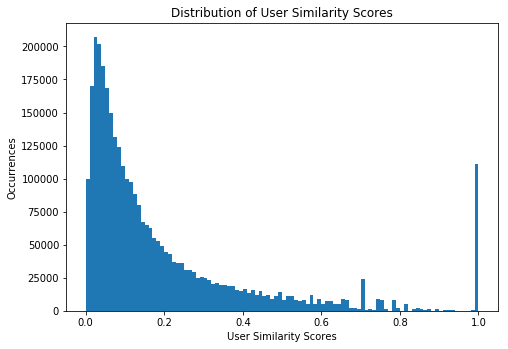

In [71]:
fig = plt.figure(figsize=(6,4))
fig.add_axes([0,0,1,1])
plt.hist(user_sims_coo.data,100);
plt.xlabel('User Similarity Scores')
plt.ylabel('Occurrences')
plt.title('Distribution of User Similarity Scores')

In [72]:
def collaborative_filter(selected_user,node_list,user_matrix,top_n_similarities):
    '''Our collaborative filter accepts a selected user, list of user nodes used to create the 
    user coordinate matrix, the user x user coordinate matrix, and the Number of top simililarities
    to return for the collaborative filter. The filter looks for users who have read similar books and returns
    a data frame the books, average user similarity, number of times the book has been read by those similar to you.
    
    input
        selected_user: integer of user id
        node_list: numpy array of users
        user_matrix: scipy.sparse.coo.coo_matrix of user x user matrix
        top_n_similarities: # of similarities to pull from (Only pull from users that are most similar)
    
    returns
        pd.DataFrame with user id and isbn number as index with the books average rating, sum of user similarity,
        average user similarity, # of times the book has been read/bought by users who read at least 1 book the 
        selected user read, sum of book ratings, average book ratings, # of explicit and implicit ratings, & average
        explicit rating 
    
    '''
    def node_similiarities(node, node_list, matrix):
        '''Creates a numpy array of node similiarities (user or books)'''
        node_agerange = G.node[node]['age_range']
        indices = np.where(matrix.row == np.where(node_list==node)[0])[0]
        matrix_sims_node = []
        matrix_sims_score = []
        nodes_sim = defaultdict(list)
        for idx in indices:
            neighbor = node_list[matrix.col[idx]]
            #if G.node[neighbor]['age_range'] == node_agerange:
            cos_sim = (matrix.data[idx])
            nodes_sim[cos_sim].append(neighbor)
        return nodes_sim
    
    def user_neighbor_books(selected_user, user_similarity_dict,top_n_similarities):
        '''accepts a 2d array with users in the first column and similarities in the 2nd
           returns top 10 books with scores'''
        books = defaultdict(lambda: defaultdict(float))
        for key in sorted(user_similarity_dict.keys(),reverse=True)[:top_n_similarities]:
            if key > 0 and key < 1:
                for usr_lookup in user_similarity_dict[key]:
                    for bk in set(G.neighbors(usr_lookup)).difference(G.neighbors(selected_user)):
                        book_rating = G[usr_lookup][bk]['Book-Rating']
                        books[bk]['count'] += 1
                        books[bk]['cosine'] += key
                        books[bk]['rating'] += book_rating
                        books[bk]['implicit_ratings'] += 1 if book_rating == 0 else 0
                        books[bk]['explicit_ratings'] += 1 if book_rating > 0 else 0
                        books[bk]['avg_cosine'] = books[bk]['cosine']/books[bk]['count']  
                        books[bk]['avg_rating'] = books[bk]['rating']/books[bk]['count']
                        if books[bk]['explicit_ratings'] > 0:
                            books[bk]['avg_explicit_rating'] = books[bk]['rating']/books[bk]['explicit_ratings']
                        if books[bk]['implicit_ratings'] > 0:
                            books[bk]['explicit_implicit_ratio'] = books[bk]['explicit_ratings']/books[bk]['implicit_ratings']
        
        return books
    
    def books_dict_to_df(books_list):
        books_list = [(b,
               d['avg_rating'],
               d['avg_explicit_rating'],        
               d['avg_cosine'],
               d['explicit_implicit_ratio'],
               d['count'],
               d['cosine'],
               d['rating'],
               d['implicit_ratings']) for b,d in zip(user_books_df.keys(),user_books_df.values())]
        df_columns = ['ISBN','avg_rating','avg_explicit_rating','avg_cosine','explicit_implicit_ratio','user_count','cosines','ratings','implicit_ratings']
        ret_df = pd.DataFrame(books_list,columns=df_columns)
        ret_df['user'] = selected_user
        return ret_df


    user_sims_nodes = node_similiarities(selected_user,user_arr,user_sims_coo)
    
    user_books_df = user_neighbor_books(selected_user=selected_user,
                                        user_similarity_dict=user_sims_nodes,
                                        top_n_similarities=top_n_similarities)
    
    res = books_dict_to_df(user_books_df).set_index('ISBN').join(bk_platform_popularity).reset_index()
    res['popularitymetric'] = res['avg_cosine']*res['platform_popularity_popularity_percent']
    return res.set_index(['user','ISBN'])


<h2>Test 1 User On Collaborative Filter</h2>

In [73]:
selected_user = 278418     
def collab_filter_recommendations(selected_user,n_recommendations=None,top_n_sim=25):
    ''' Accepts the selected user and total n_recommendations to return. 
        Returns the dataframe in collaborative_filter with if the user actually read the book or not'''
    recommended_books = collaborative_filter(selected_user,user_arr,user_sims_coo,top_n_sim)
    recommended_books = recommended_books.sort_values(['user_count','cosines'],ascending=False)
    recommended_books = recommended_books.head(n_recommendations)

    # Pull actual purchases
    sel_user_actual = ratings_us_test[ratings_us_test['User-ID']==selected_user]['ISBN'].to_frame()
    sel_user_actual['read'] = 1
    sel_user_actual['user'] = selected_user
    sel_user_actual.set_index(['user','ISBN'],inplace=True)

    # TOP N Recommendation based on cosines
    return recommended_books.join(sel_user_actual).fillna(0)

collab_filter_recommendations(selected_user).head(10)

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0515132020    7.000000             9.333333    0.109906   
       0971880107    1.666667             5.000000    0.142279   
       0345391802    0.000000             0.000000    0.133490   
       0316899984    0.000000             0.000000    0.133490   
       051513287X    4.000000             8.000000    0.132706   
       0312983271    0.000000             0.000000    0.123221   
       0440221471    3.500000             7.000000    0.122135   
       0345413881    0.000000             0.000000    0.112740   
       0553583441    2.500000             5.000000    0.104472   
       0446608815    3.500000             7.000000    0.101598   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0515132020                      3.0         4.0  0.439626     28.0   
       0971880107                      0.5         3.0  0.426838      5.0   
       0345391802                      0.0         2.0  0.266979      0.0   
       0316899984                      0.0         2.0  0.266979      0.0   
       051513287X                      1.0         2.0  0.265411      8.0   
       0312983271                      0.0         2.0  0.246442      0.0   
       0440221471                      1.0         2.0  0.244270      7.0   
       0345413881                      0.0         2.0  0.225480      0.0   
       0553583441                      1.0         2.0  0.208944      5.0   
       0446608815                      1.0         2.0  0.203196      7.0   

                   implicit_ratings  platform_popularity  platform_avg_rating  \
user   ISBN                                                                     
278418 0515132020               1.0                  170             2.982353   
       0971880107               2.0                 1202             1.082363   
       0345391802               2.0                  100             4.410000   
       0316899984               2.0                  148             2.358108   
       051513287X               1.0                  192             2.921875   
       0312983271               2.0                  199             3.000000   
       0440221471               1.0                  354             2.658192   
       0345413881               2.0                  103             2.640777   
       0553583441               1.0                   83             2.144578   
       0446608815               1.0                  140             2.850000   

                   platform_popularity_popularity_percent  popularitymetric  \
user   ISBN                                                                   
278418 0515132020                                0.141431          0.015544   
       0971880107                                1.000000          0.142279   
       0345391802                                0.083195          0.011106   
       0316899984                                0.123128          0.016436   
       051513287X                                0.159734          0.021198   
       0312983271                                0.165557          0.020400   
       0440221471                                0.294509          0.035970   
       0345413881                                0.085691          0.009661   
       0553583441                                0.069052          0.007214   
       0446608815                                0.116473          0.011833   

                   read  
user   ISBN              
278418 0515132020   0.0  
       0971880107   0.0  
       0345391802   0.0  
       0316899984   0.0  
       051513287X   0.0  
       0312983271   0.0  
       0440221471   0.0  
       0345413881   0.0  
       0553583441   0.0  
       0446608815   0.0

<h2>Take 75% of ratings from test set, train the model then test on the 25% of ratings</h2>

In [74]:
#Filter on number of books a user read in test set
test_ratings_user_count = 30

test_ratings_user_valcount = ratings_us_test['User-ID'].value_counts()
filtered_test_ratings = test_ratings_user_valcount[test_ratings_user_valcount>test_ratings_user_count]


## Split test set to random forest training and test set

train_ratings,test_ratings = train_test_split(filtered_test_ratings,test_size=.25)
users_to_train = train_ratings.index.values
users_to_test = test_ratings.index.values

In [75]:
top_n_cosines = 5
n_recommendations = 300

metrics = np.empty(len(users_to_train))

group_df = []

for i,sel_user in enumerate(users_to_train):
    group_df.append(collab_filter_recommendations(sel_user,n_recommendations,top_n_sim=top_n_cosines))
    
group_df = pd.concat(group_df).fillna(0)    

In [76]:
group_df.head(20)
X = group_df.drop(['read'],axis=1)
y = group_df['read']
print(X.shape)

(23639, 12)


<h2>Import sklearn items</h2>

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_score

<h2>Logistic Regression</h2>

In [78]:
# Log reg model
lr = LogisticRegression()
lr.fit(X,y)

log_reg_coefs = pd.DataFrame(lr.coef_,columns=X.columns).T.sort_values(0,ascending=False)

y_pred = lr.predict(X)
y_pred_proba = lr.predict_proba(X)[:,1]
fpr,tpr,thresholds = roc_curve(y,y_pred)

In [79]:
print('Log Reg Confusion Matrix\n')
print(pd.crosstab(y,lr.predict(X), rownames=['True'], colnames=['Predicted'],))

Log Reg Confusion Matrix

Predicted    0.0  1.0
True                 
0.0        22978   11
1.0          631   19


In [80]:
print('Log Reg Classification Report\n')
print(classification_report(y,y_pred,target_names=['Not Read','Read']))

Log Reg Classification Report

             precision    recall  f1-score   support

   Not Read       0.97      1.00      0.99     22989
       Read       0.63      0.03      0.06       650

avg / total       0.96      0.97      0.96     23639



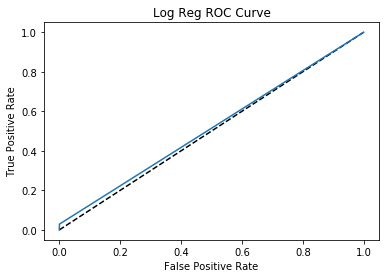

In [81]:
plt.plot([0,1],[0,1],'k--');
plt.plot(fpr,tpr, label='Log Reg');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Log Reg ROC Curve');

<h2>Logistic regression over predicts books that are not purchased/read as not purchased/read. With our goal being to recommend the books that users would want to buy, we need to maximize that metric.</h2><br>
<h2>Next, we'll try a random forest classifier</h2>

In [82]:
## Random forests classifier using randomized grid search to find best parameters
def scoring(model,x,y):
    y_pred = model.predict(x)
    return precision_score(y,y_pred,pos_label=1)

params = {'n_estimators':np.linspace(1,100,100,dtype=np.int),
          'min_samples_split':[2,3,4,5,6,7,8],
          'criterion':['gini','entropy'],
          'min_samples_leaf':[1,2,3,4,5,6,7],}

rfc = RandomForestClassifier()
rfcgrid = RandomizedSearchCV(rfc,params,scoring=scoring,n_iter=50,n_jobs=-1)
rfcgrid.fit(X,y)

best__n_estimators = rfcgrid.best_params_['n_estimators']
best__criterion = rfcgrid.best_params_['criterion']
best__min_samples_leaf = rfcgrid.best_params_['min_samples_leaf']
best__min_samples_split = rfcgrid.best_params_['min_samples_split']
print('Random Forests Grid Search')

print('Best Random Forests grid search score: {:.4f}'.format(rfcgrid.best_score_))
print('''Best n_estimators: {:.4f} 
Best Criterion: {} 
Best min_samples_leaf: {}
Best min_samples_split: {}'''.format(best__n_estimators,
                                     best__criterion,
                                     best__min_samples_leaf,
                                     best__min_samples_split),end='\n\n')


Random Forests Grid Search
Best Random Forests grid search score: 0.5111
Best n_estimators: 11.0000 
Best Criterion: entropy 
Best min_samples_leaf: 7
Best min_samples_split: 4



In [83]:
## Fit actual RFC model with best parameters from grid search

rfc = RandomForestClassifier(n_estimators=best__n_estimators,
                             criterion=best__criterion,
                             min_samples_leaf=best__min_samples_leaf,
                             min_samples_split=best__min_samples_split,
                             n_jobs=-1)
rfc.fit(X,y)

y_pred = rfc.predict(X)
y_pred_proba = rfc.predict_proba(X)[:,1]
fpr,tpr,thresholds = roc_curve(y,y_pred)

In [84]:
print('Random Forests Confusion Matrix\n')
print(pd.crosstab(y,y_pred, rownames=['True'], colnames=['Predicted'],))

Random Forests Confusion Matrix

Predicted    0.0  1.0
True                 
0.0        22981    8
1.0          611   39


In [85]:
print('Random Forests Classification Report\n')
print(classification_report(y,y_pred,target_names=['Not Read','Read']))

Random Forests Classification Report

             precision    recall  f1-score   support

   Not Read       0.97      1.00      0.99     22989
       Read       0.83      0.06      0.11       650

avg / total       0.97      0.97      0.96     23639



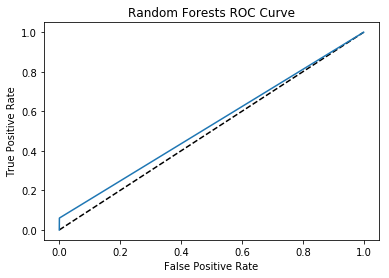

In [86]:
plt.plot([0,1],[0,1],'k--');
plt.plot(fpr,tpr, label='Random Forests');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Random Forests ROC Curve');

In [87]:
print('Feature Importancs\n')
print(pd.Series(rfc.feature_importances_,X.columns).sort_values(ascending=False))

Feature Importancs

popularitymetric                          0.150458
cosines                                   0.145452
avg_cosine                                0.143063
platform_avg_rating                       0.134212
platform_popularity_popularity_percent    0.117533
platform_popularity                       0.108343
ratings                                   0.082847
avg_explicit_rating                       0.049095
avg_rating                                0.026162
user_count                                0.025547
implicit_ratings                          0.013163
explicit_implicit_ratio                   0.004124
dtype: float64


In [88]:
print('Random Forests Cross Val Score on Precision Metric')
def scoring(model,X,y):
    y_pred=model.predict(X)
    return precision_score(y,y_pred,labels=['Not read','Read'],pos_label=1)

print('Overall model score: {:.3f}'.format(scoring(rfc,X,y),end='\n\n'))
print('Cross Validated Model Scores: {}'.format(cross_val_score(rfc,X,y,scoring=scoring,cv=5)))

Random Forests Cross Val Score on Precision Metric
Overall model score: 0.830
Cross Validated Model Scores: [0.5        0.75       0.5        0.18181818 0.        ]


<h2>Test on hold out data</h2>

In [89]:
## Build dataframe of Recommended books from holdout data
group_df = []

for i,sel_user in enumerate(users_to_test):
    group_df.append(collab_filter_recommendations(sel_user,n_recommendations,top_n_sim=top_n_cosines))
    
group_df = pd.concat(group_df).fillna(0)    

In [90]:
## Break collaborative filter into recommendations
X_test = group_df.drop(['read'],axis=1)
y_test = group_df['read']

In [91]:
## Get the precision of hold out data in Random Forests Classifier
holdout_score = precision_score(y_test,rfc.predict(X_test),labels=['Not read','Read'])
print('Holdout Data Precision Score: {:.3f}'.format(holdout_score))

Holdout Data Precision Score: 0.571


<h2>Pull individual recommendations for users using Random Forest Classifer</h2>

In [92]:
def recommender(model,usr,top_n=10):
    user_recommendations = collab_filter_recommendations(usr)
    
    if len(user_recommendations) > 0:
        X_sample = user_recommendations.drop(['read'],axis=1)
        user_recommendations['predicted'] = model.predict(X_sample)
        return user_recommendations.sort_values(['read','predicted','popularitymetric','cosines'],ascending=False)[:top_n]
    
    return "No Recommendations"

In [93]:
selected_user = 278418
res = recommender(rfc,selected_user,10)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0345391055    0.000000                  0.0    0.102684   
       042513525X    0.000000                  0.0    0.102684   
       0446364800    0.000000                  0.0    0.102684   
       1562925539    0.000000                  0.0    0.164295   
       0971880107    1.666667                  5.0    0.142279   
       0316666343   10.000000                 10.0    0.105661   
       0316601950    0.000000                  0.0    0.164295   
       0060976845    0.000000                  0.0    0.164295   
       059035342X    0.000000                  0.0    0.102684   
       0671027360    0.000000                  0.0    0.099232   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0345391055                      0.0         1.0  0.102684      0.0   
       042513525X                      0.0         1.0  0.102684      0.0   
       0446364800                      0.0         1.0  0.102684      0.0   
       1562925539                      0.0         1.0  0.164295      0.0   
       0971880107                      0.5         3.0  0.426838      5.0   
       0316666343                      0.0         1.0  0.105661     10.0   
       0316601950                      0.0         1.0  0.164295      0.0   
       0060976845                      0.0         1.0  0.164295      0.0   
       059035342X                      0.0         1.0  0.102684      0.0   
       0671027360                      0.0         1.0  0.099232      0.0   

                   implicit_ratings  platform_popularity  platform_avg_rating  \
user   ISBN                                                                     
278418 0345391055               1.0                  188             2.159574   
       042513525X               1.0                  117             2.504274   
       0446364800               1.0                  112             2.473214   
       1562925539               1.0                    3             0.000000   
       0971880107               2.0                 1202             1.082363   
       0316666343               0.0                  934             4.655246   
       0316601950               1.0                  442             3.647059   
       0060976845               1.0                  349             3.378223   
       059035342X               1.0                  488             4.918033   
       0671027360               1.0                  486             3.767490   

                   platform_popularity_popularity_percent  popularitymetric  \
user   ISBN                                                                   
278418 0345391055                                0.156406          0.016060   
       042513525X                                0.097338          0.009995   
       0446364800                                0.093178          0.009568   
       1562925539                                0.002496          0.000410   
       0971880107                                1.000000          0.142279   
       0316666343                                0.777038          0.082103   
       0316601950                                0.367720          0.060415   
       0060976845                                0.290349          0.047703   
       059035342X                                0.405990          0.041689   
       0671027360                                0.404326          0.040122   

                   read  predicted  
user   ISBN                         
278418 0345391055   1.0        0.0  
       042513525X   1.0        0.0  
       0446364800   1.0        0.0  
       1562925539   1.0        0.0  
       0971880107   0.0        0.0  
       0316666343   0.0        0.0  
       0316601950   0.0        0.0  
       0060976845   0.0        0.0  
       05

In [94]:
selected_user = 111422
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
111422 0060928336         8.0                  8.0    0.139759   
       0316666343        10.0                 10.0    0.072454   
       0805063897         9.0                  9.0    0.281381   
       0743418174         0.0                  0.0    0.139759   
       0142001740         0.0                  0.0    0.072454   
       0679781587         9.0                  9.0    0.072454   
       0316776963         0.0                  0.0    0.139759   
       059035342X         0.0                  0.0    0.072454   
       0156027321         0.0                  0.0    0.106107   
       067976402X        10.0                 10.0    0.072454   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
111422 0060928336                      0.0         1.0  0.139759      8.0   
       0316666343                      0.0         1.0  0.072454     10.0   
       0805063897                      0.0         1.0  0.281381      9.0   
       0743418174                      0.0         1.0  0.139759      0.0   
       0142001740                      0.0         1.0  0.072454      0.0   
       0679781587                      0.0         1.0  0.072454      9.0   
       0316776963                      0.0         1.0  0.139759      0.0   
       059035342X                      0.0         1.0  0.072454      0.0   
       0156027321                      0.0         2.0  0.212214      0.0   
       067976402X                      0.0         1.0  0.072454     10.0   

                   implicit_ratings  platform_popularity  platform_avg_rating  \
user   ISBN                                                                     
111422 0060928336               0.0                  595             3.563025   
       0316666343               0.0                  934             4.655246   
       0805063897               0.0                  227             4.215859   
       0743418174               1.0                  394             4.253807   
       0142001740               1.0                  533             4.307692   
       0679781587               0.0                  532             4.409774   
       0316776963               1.0                  262             3.916031   
       059035342X               1.0                  488             4.918033   
       0156027321               2.0                  333             3.867868   
       067976402X               0.0                  475             3.191579   

                   platform_popularity_popularity_percent  popularitymetric  \
user   ISBN                                                                   
111422 0060928336                                0.495008          0.069182   
       0316666343                                0.777038          0.056300   
       0805063897                                0.188852          0.053139   
       0743418174                                0.327787          0.045811   
       0142001740                                0.443428          0.032128   
       0679781587                                0.442596          0.032068   
       0316776963                                0.217970          0.030463   
       059035342X                                0.405990          0.029416   
       0156027321                                0.277038          0.029396   
       067976402X                                0.395175          0.028632   

                   read  predicted  
user   ISBN                         
111422 0060928336   0.0        0.0  
       0316666343   0.0        0.0  
       0805063897   0.0        0.0  
       0743418174   0.0        0.0  
       0142001740   0.0        0.0  
       0679781587   0.0        0.0  
       0316776963   0.0        0.0  
       059035342X   0.0        0.0  
       01

In [95]:
selected_user = 35859
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user  ISBN                                                      
35859 0440221471         7.0                  7.0    0.069070   
      0440241073         4.0                  8.0    0.066763   
      0440225701         0.0                  0.0    0.069070   
      0446610038        10.0                 10.0    0.062262   
      0446612790         6.0                  6.0    0.063180   
      0786881852         0.0                  0.0    0.062250   
      0312980140         9.0                  9.0    0.063452   
      0439139600        10.0                 10.0    0.062262   
      0449221504         9.0                  9.0    0.062262   
      0399147195         0.0                  0.0    0.078747   

                  explicit_implicit_ratio  user_count   cosines  ratings  \
user  ISBN                                                                 
35859 0440221471                      0.0         1.0  0.069070      7.0   
      0440241073                      1.0         2.0  0.133526      8.0   
      0440225701                      0.0         1.0  0.069070      0.0   
      0446610038                      0.0         1.0  0.062262     10.0   
      0446612790                      0.0         1.0  0.063180      6.0   
      0786881852                      0.0         1.0  0.062250      0.0   
      0312980140                      0.0         3.0  0.190357     27.0   
      0439139600                      0.0         1.0  0.062262     10.0   
      0449221504                      0.0         1.0  0.062262      9.0   
      0399147195                      0.0         1.0  0.078747      0.0   

                  implicit_ratings  platform_popularity  platform_avg_rating  \
user  ISBN                                                                     
35859 0440221471               0.0                  354             2.658192   
      0440241073               1.0                  344             2.947674   
      0440225701               1.0                  321             2.635514   
      0446610038               0.0                  325             3.427692   
      0446612790               0.0                  184             3.081522   
      0786881852               1.0                  174             3.477011   
      0312980140               0.0                  162             3.820988   
      0439139600               0.0                  151             4.986755   
      0449221504               0.0                  126             2.182540   
      0399147195               1.0                   99             3.414141   

                  platform_popularity_popularity_percent  popularitymetric  \
user  ISBN                                                                   
35859 0440221471                                0.294509          0.020342   
      0440241073                                0.286190          0.019107   
      0440225701                                0.267055          0.018446   
      0446610038                                0.270383          0.016835   
      0446612790                                0.153078          0.009671   
      0786881852                                0.144759          0.009011   
      0312980140                                0.134775          0.008552   
      0439139600                                0.125624          0.007822   
      0449221504                                0.104825          0.006527   
      0399147195                                0.082363          0.006486   

                  read  predicted  
user  ISBN                         
35859 0440221471   1.0        0.0  
      0440241073   1.0        0.0  
      0440225701   1.0        0.0  
      0446610038   1.0        0.0  
      0446612790   1.0        0.0  
      0786881852   1.0        0.0  
      0312980140   1.0        0.0  
      0439139600   1.0        0.0  
      0449221504   1.0        0.0  
      0399147195   1.0        

In [96]:
selected_user = 153662
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
153662 0515131229        8.00                 8.00    0.103596   
       0515128554        7.75                 7.75    0.098757   
       0373483503        6.60                 8.25    0.101868   
       0515114006        7.80                 7.80    0.113574   
       0316666343        5.00                 7.50    0.083869   
       0440211727        8.00                 8.00    0.079549   
       0842329129        0.00                 0.00    0.079916   
       068484477X        0.00                 0.00    0.075704   
       0385505833       10.00                10.00    0.085846   
       0385503822        5.00                 5.00    0.084742   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
153662 0515131229                      0.0         3.0  0.310787     24.0   
       0515128554                      0.0         8.0  0.790053     62.0   
       0373483503                      4.0         5.0  0.509338     33.0   
       0515114006                      0.0         5.0  0.567870     39.0   
       0316666343                      2.0         3.0  0.251608     15.0   
       0440211727                      0.0         2.0  0.159098     16.0   
       0842329129                      0.0         1.0  0.079916      0.0   
       068484477X                      0.0         1.0  0.075704      0.0   
       0385505833                      0.0         2.0  0.171692     20.0   
       0385503822                      0.0         1.0  0.084742      5.0   

                   implicit_ratings  platform_popularity  platform_avg_rating  \
user   ISBN                                                                     
153662 0515131229               0.0                  217             3.350230   
       0515128554               0.0                  140             3.157143   
       0373483503               1.0                   65             2.138462   
       0515114006               0.0                   39             2.794872   
       0316666343               1.0                  934             4.655246   
       0440211727               0.0                  402             3.009950   
       0842329129               1.0                  272             3.992647   
       068484477X               1.0                  270             3.074074   
       0385505833               0.0                  168             4.410714   
       0385503822               0.0                  169             4.000000   

                   platform_popularity_popularity_percent  popularitymetric  \
user   ISBN                                                                   
153662 0515131229                                0.180532          0.018702   
       0515128554                                0.116473          0.011502   
       0373483503                                0.054077          0.005509   
       0515114006                                0.032446          0.003685   
       0316666343                                0.777038          0.065170   
       0440211727                                0.334443          0.026605   
       0842329129                                0.226290          0.018084   
       068484477X                                0.224626          0.017005   
       0385505833                                0.139767          0.011998   
       0385503822                                0.140599          0.011915   

                   read  predicted  
user   ISBN                         
153662 0515131229   1.0        1.0  
       0515128554   1.0        1.0  
       0373483503   1.0        1.0  
       0515114006   1.0        1.0  
       0316666343   1.0        0.0  
       0440211727   1.0        0.0  
       0842329129   1.0        0.0  
       068484477X   1.0        0.0  
       03

In [97]:
selected_user = 73394
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user  ISBN                                                      
73394 0141000198         0.0                  0.0    0.185888   
      0515119784         0.0                  0.0    0.317937   
      0312195516         2.0                  4.0    0.229873   
      044023722X         8.0                  8.0    0.176834   
      0679781587         7.0                  7.0    0.171083   
      0385484518         0.0                  0.0    0.185888   
      0060959037         0.0                  0.0    0.236596   
      0743237188         0.0                  0.0    0.173111   
      0440224675         6.0                  6.0    0.167299   
      0425163407         6.0                  6.0    0.317937   

                  explicit_implicit_ratio  user_count   cosines  ratings  \
user  ISBN                                                                 
73394 0141000198                      0.0         1.0  0.185888      0.0   
      0515119784                      0.0         1.0  0.317937      0.0   
      0312195516                      1.0         2.0  0.459745      4.0   
      044023722X                      0.0         1.0  0.176834      8.0   
      0679781587                      0.0         1.0  0.171083      7.0   
      0385484518                      0.0         1.0  0.185888      0.0   
      0060959037                      0.0         1.0  0.236596      0.0   
      0743237188                      0.0         1.0  0.173111      0.0   
      0440224675                      0.0         1.0  0.167299      6.0   
      0425163407                      0.0         1.0  0.317937      6.0   

                  implicit_ratings  platform_popularity  platform_avg_rating  \
user  ISBN                                                                     
73394 0141000198               1.0                  161             3.068323   
      0515119784               1.0                   54             2.833333   
      0312195516               1.0                  565             4.359292   
      044023722X               0.0                  544             3.218750   
      0679781587               0.0                  532             4.409774   
      0385484518               1.0                  322             4.326087   
      0060959037               1.0                  191             4.450262   
      0743237188               1.0                  244             3.512295   
      0440224675               0.0                  249             2.393574   
      0425163407               0.0                  131             2.870229   

                  platform_popularity_popularity_percent  popularitymetric  \
user  ISBN                                                                   
73394 0141000198                                0.133943          0.024898   
      0515119784                                0.044925          0.014283   
      0312195516                                0.470050          0.108052   
      044023722X                                0.452579          0.080032   
      0679781587                                0.442596          0.075721   
      0385484518                                0.267887          0.049797   
      0060959037                                0.158902          0.037596   
      0743237188                                0.202995          0.035141   
      0440224675                                0.207155          0.034657   
      0425163407                                0.108985          0.034650   

                  read  predicted  
user  ISBN                         
73394 0141000198   1.0        0.0  
      0515119784   1.0        0.0  
      0312195516   0.0        0.0  
      044023722X   0.0        0.0  
      0679781587   0.0        0.0  
      0385484518   0.0        0.0  
      0060959037   0.0        0.0  
      0743237188   0.0        0.0  
      0440224675   0.0        0.0  
      0425163407   0.0        